In [25]:
import wandb
import torch
# import numpy as np
# import pandas as pd
# from tqdm import tqdm
# import seaborn as sns
# import matplotlib.pyplot as plt
# import wandb

# from sklearn.metrics import roc_auc_score, confusion_matrix
# from sklearn.preprocessing import binarize


# from models import MLP
from data.Datasets import PatchesDatasetCooccurrences
from data.PatchesProviders import MultipleRasterPatchProvider, RasterPatchProvider

In [22]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"DEVICE: {dev}\n")

DEVICE: cuda



In [33]:
wandb_entity='deephsm'
wandb_project='spatial_extent_glc23_v2'
wandb_id='kwkglhrl'
wandb_config = wandb.api.run_config(entity=wandb_entity, project=wandb_project, run=wandb_id)[1]

run_name = '0129_MLP_env_1x1_an_full_loss'

In [19]:
# patch_size = wandb_config['env_patch_size']['value']
# flatten = True
# learning_rate = wandb_config['lr']['value']
# n_layers = wandb_config['n_layers']['value']
# width = wandb_config['width']['value']
patch_size = 1
flatten = True
learning_rate = 1e-3
n_layers = 5
width = 1000

In [23]:
datadir = 'data/full_data/'
bioclim_dir = datadir+'EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/'
soil_dir = datadir+'EnvironmentalRasters/Soilgrids/'
landcover_dir = datadir+'EnvironmentalRasters/LandCover/LandCover_MODIS_Terra-Aqua_500m.tif'
po_path = datadir+'Presence_only_occurrences/Presences_only_train_sampled_10_percent_min_100_occurrences.csv' #Presences_only_train_sampled_25_percent_min_10_occurrences.csv'
pa_path = datadir+'Presence_Absence_surveys/Presences_Absences_train.csv'

In [27]:
p_bioclim = MultipleRasterPatchProvider(bioclim_dir, size=patch_size, flatten=flatten) 
p_soil = MultipleRasterPatchProvider(soil_dir, size=patch_size, flatten=flatten) 
p_landcover = RasterPatchProvider(landcover_dir, size=patch_size, flatten=flatten)

In [28]:
train_data = PatchesDatasetCooccurrences(occurrences=po_path, providers=(p_bioclim, p_soil, p_landcover))
print(f"\nTRAINING DATA: n_items={len(train_data)}, n_species={len(train_data.species)}")

n_features = train_data[0][0].shape[0]
n_species = len(train_data.species)
print(f"nb of features = {n_features}")

val_data = PatchesDatasetCooccurrences(occurrences=pa_path, providers=(p_bioclim, p_soil, p_landcover), species=train_data.species)
print(f"\nVALIDATION DATA: n_items={len(val_data)}, n_species={len(val_data.species)}")


TRAINING DATA: n_items=311172, n_species=970
nb of features = 41

VALIDATION DATA: n_items=7438, n_species=970


In [34]:
checkpoint = torch.load(f"models/{run_name}/best_val_loss.pth")
best_val_loss_epoch = checkpoint['epoch']
best_val_loss_epoch

63

In [8]:
model = MLP(n_features, n_species, n_layers, width).to(dev)
model.load_state_dict(checkpoint['state_dict'])
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [9]:
model.eval()
val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=1024, num_workers=8)
labels_list, y_pred_list = [], []

for inputs, labels in tqdm(val_loader):
    inputs = inputs.to(torch.float32).to(dev)
    labels = labels.to(torch.float32).to(dev)
    labels_list.append(labels.cpu().detach().numpy())

    y_pred = model(inputs)
    y_pred_sigmoid = torch.sigmoid(y_pred)
    y_pred_list.append(y_pred_sigmoid.cpu().detach().numpy())

labels = np.concatenate(labels_list)
y_pred = np.concatenate(y_pred_list)

100%|██████████| 69/69 [00:54<00:00,  1.26it/s]


In [37]:
for inputs, labels in tqdm(val_loader):
    inputs = inputs.to(torch.float32).to(dev)
    labels = labels.to(torch.float32).to(dev)
    labels_list.append(labels.cpu().detach().numpy())

    y_pred = model(inputs)
    break

  0%|          | 0/69 [00:15<?, ?it/s]


In [43]:
loss_fn = torch.nn.BCEWithLogitsLoss()
loss_fn(y_pred, labels)

tensor(0.1052, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [44]:
def log_loss(pred):
    return -torch.log(pred + 1e-5)

In [82]:
y_pred_sigmoid.size(0)

1024

In [78]:
y_pred_sigmoid = torch.sigmoid(y_pred)
batch_size = 1024



loss_dl_pos = (log_loss(y_pred_sigmoid) * labels * species_weights.repeat((batch_size, 1))).mean()
loss_dl_neg = (log_loss(1 - y_pred_sigmoid) * (1 - labels) * (species_weights/(species_weights - 1)).repeat((batch_size, 1))).mean() 
print(loss_dl_pos)
print(loss_dl_neg)
print(loss_dl_neg+loss_dl_pos)
    

tensor(83.4760, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0152, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(83.4912, device='cuda:0', grad_fn=<AddBackward0>)


In [10]:
labels.shape

(70594, 970)

In [11]:
y_pred.shape

(70594, 970)

In [15]:
np.sum(labels)

1166710.0

In [36]:
f1_list = []
for thresh in [0.01, 0.03, 0.07]:
    print(thresh)
    y_pred_bin = binarize(y_pred, threshold=thresh)
    f1_sum = 0
    for i in range(labels.shape[0]):
        tn, fp, fn, tp = confusion_matrix(labels[i,:], y_pred_bin[i,:]).ravel()
        f1 = tp / (tp + ((fp+fn)/2))
        f1_sum += f1
    f1_mean = f1_sum / labels.shape[0]
    print('.... f1 = ', f1_mean)
    f1_list.append(f1_mean)

# 0.01 .... f1 =  0.03514620632302868
# 0.03 .... f1 =  0.002722488766607361
# 0.05 .... f1 =  0.0017644476450584833
# 0.07 .... f1 =  0.0014414951872067973
# 0.1  .... f1 =  0.0010351030798469321

0.01
.... f1 =  0.03514620632302868
0.03
.... f1 =  0.002722488766607361
0.07
.... f1 =  0.0014414951872067973


In [19]:
y_pred_bin = binarize(y_pred, threshold=0.1)

In [31]:
f1_sum = 0
for i in range(labels.shape[0]):
    tn, fp, fn, tp = confusion_matrix(labels[i,:], y_pred_bin[i,:]).ravel()
    f1 = tp / (tp + ((fp+fn)/2))
    f1_sum += f1
f1_mean = f1_sum / labels.shape[0]
print(f1_mean)

0.0010351030798469321


In [113]:
auc_list = []
for i in range(labels.shape[1]):
    auc_list.append(roc_auc_score(labels[:,i], y_pred[:,i]))

(array([ 11.,  15.,  12.,  12.,  19.,  23.,  49.,  68.,  88., 106., 107.,
         91.,  86.,  74.,  62.,  53.,  40.,  19.,  21.,  14.]),
 array([0.00592261, 0.05519899, 0.10447537, 0.15375175, 0.20302813,
        0.25230451, 0.30158089, 0.35085727, 0.40013365, 0.44941003,
        0.49868641, 0.54796279, 0.59723917, 0.64651555, 0.69579193,
        0.74506831, 0.79434469, 0.84362106, 0.89289744, 0.94217382,
        0.9914502 ]),
 <BarContainer object of 20 artists>)

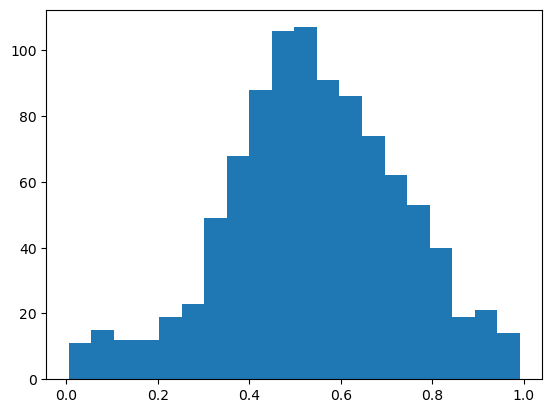

In [114]:
plt.hist(auc_list, bins=20)

In [115]:
po_data = pd.read_csv(po_path, sep=";", header='infer', low_memory=False)

In [116]:
species_counts = po_data.drop_duplicates(['speciesId','lat','lon','patchID','dayOfYear']).groupby('speciesId')[['glcID']].nunique()['glcID'].values
species_counts

array([237, 425, 224, 437, 500, 141, 415, 439, 441, 102, 110, 185, 444,
       112, 276, 454, 100, 156, 466, 444, 456, 436, 319, 213, 117, 151,
       492, 298, 479, 348, 431, 148, 101, 129, 437, 143, 458, 276, 448,
       315, 445, 488, 458, 173, 115, 436, 130, 493, 452, 425, 241, 292,
       226, 456, 440, 439, 455, 458, 464, 442, 187, 451, 111, 446, 437,
       104, 156, 430, 235, 472, 429, 416, 444, 455, 467, 450, 470, 464,
       461, 441, 450, 325, 481, 298, 146, 426, 467, 108, 115, 118, 129,
       483, 451, 481, 462, 443, 418, 458, 190, 461, 406, 464, 467, 161,
       463, 460, 445, 423, 434, 124, 445, 444, 240, 435, 406, 173, 161,
       408, 446, 284, 444, 147, 273, 465, 127, 382, 317, 124, 189, 471,
       424, 475, 130, 232, 109, 323, 126, 404, 377, 260, 412, 423, 463,
       248, 128, 436, 422, 380, 452, 127, 335, 437, 419, 195, 437, 472,
       428, 429, 150, 450, 458, 428, 157, 252, 426, 439, 129, 438, 444,
       145, 446, 445, 359, 301, 140, 310, 461, 116, 221, 467, 14

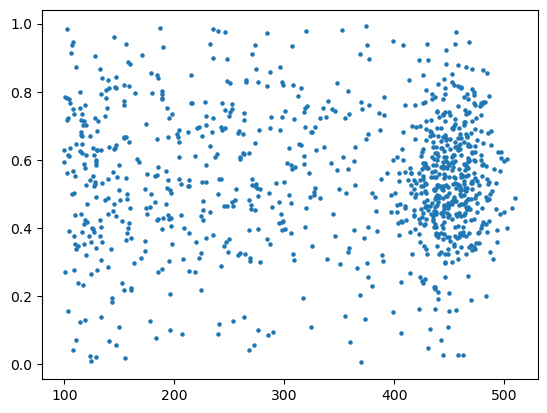

In [117]:
plt.scatter(species_counts, auc_list, s=5)
# plt.hist2d(species_counts, auc_list, bins=20, cmap='Blues')